In [2]:
import numpy as np
import matplotlib.pyplot as plt
import string
from sklearn.model_selection import train_test_split

In [3]:
input_files = [
  'edgar_allan_poe.txt',
  'robert_frost.txt',
]

In [6]:
# collect data into lists
input_texts = []
labels = []

for label, f in enumerate(input_files):
  print(f"{f} corresponds to label {label}")

  for line in open(f, encoding='utf-8'):
    line = line.rstrip().lower()
    if line:
      # remove punctuation
      line = line.translate(str.maketrans('', '', string.punctuation))

      input_texts.append(line)
      labels.append(label)

poe_inputs=input_texts[0:labels.index(1)]
frost_inputs=input_texts[labels.index(1):]

edgar_allan_poe.txt corresponds to label 0
robert_frost.txt corresponds to label 1


In [21]:
samples_poe=labels.index(1)
samples_frost=len(labels)-labels.index(1)
len(labels)==samples_poe+samples_frost

True

In [44]:
# Train/Test split
test_size = 0.2
random_state = 10

X0_train, X0_test, y0_train, y0_test = train_test_split(poe_inputs, labels[0:labels.index(1)], test_size=test_size, random_state=random_state)
X1_train, X1_test, y1_train, y1_test = train_test_split(frost_inputs, labels[labels.index(1):], test_size=test_size, random_state=random_state)

X_train, X_test, y_train, y_test = train_test_split(input_texts, labels, test_size=test_size, random_state=random_state)


In [47]:
X_train

['of the bells',
 'in youth i have known one with whom the earth',
 'their odorous souls in an ecstatic death',
 'in state his glory well befitting',
 'about where henry hudsons gone',
 'since it flickers up to heaven through the night',
 'is but a dimremembered story',
 'or that the thrill of a single kiss',
 'and both of our united strengths to do it',
 'of cypress with psyche my soul',
 'but wait until i give you a hand up',
 'another from the kitchen to the bedroom',
 'i fancied when i looked at six oclock',
 'and i dont mean just skulls of rogers rangers',
 'have gone to their eternal rest',
 'nor need you mind the serial ordeal',
 'i dont just see him living many years',
 'from the sun and stars whence he had drawn forth',
 'here are your waters and your watering place',
 'and spoke of the lettered',
 'which is wrong',
 'science true daughter of old time thou art',
 'the thought of my attempting such a stray',
 'it will go hard with john what will he do',
 'he looked back up the 

In [49]:
X_train[0].split()

['of', 'the', 'bells']

In [50]:
idx = 1
word2idx = {'<unk>': 0}

# populate word2idx
for text in X_train:
    tokens = text.split()
    for token in tokens:
      if token not in word2idx:
        word2idx[token] = idx
        idx += 1
print(len(word2idx))

In [54]:
# convert data into integer format
train_text_int = []
test_text_int = []

for text in X_train:
  tokens = text.split()
  line_as_int = [word2idx[token] for token in tokens]
  train_text_int.append(line_as_int)

for text in X_test:
  tokens = text.split()
  line_as_int = [word2idx.get(token, 0) for token in tokens]
  test_text_int.append(line_as_int)

In [68]:
test_text_int[0:4]

[[6, 2085, 352, 285, 2, 1122, 74, 147, 1056],
 [881, 58, 135, 601, 4, 2, 602],
 [47, 2, 0, 1853],
 [886, 802, 803, 48, 1, 222, 98, 822]]

In [180]:
# Initialize State Transition Matrix & Distribution


# ones works for add-one smoothing
A0 = np.ones((V, V))
pi0 = np.ones(V)
A1 = np.ones((V, V))
pi1 = np.ones(V)

In [166]:
def compute_counts(text2int, A, pi):
    for token in text2int:
        for i,idx in enumerate(token):
            if i==0:
                pi[idx]+=1
            else:
                A[idx,token[i-1]]+=1

In [181]:
# Part of Fitting the data - Training (Learning A,π)

compute_counts([t for t, y in zip(train_text_int, y_train) if y == 0], A0, pi0)
compute_counts([t for t, y in zip(train_text_int, y_train) if y == 1], A1, pi1)

# normalize A and pi so they are valid probability matrices
# convince yourself that this is equivalent to the formulas shown before

A0 /= A0.sum(axis=0, keepdims=True)
pi0 /= pi0.sum()
A1 /= A1.sum(axis=0, keepdims=True)
pi1 /= pi1.sum()

# Compute Logarithms

logA0 = np.log(A0)
logpi0 = np.log(pi0)
logA1 = np.log(A1)
logpi1 = np.log(pi1)

In [182]:
print(sum(A0)," , ",sum(A1))
np.sum(pi0)==np.sum(pi1)
sum(A0)

[1. 1. 1. ... 1. 1. 1.]  ,  [1. 1. 1. ... 1. 1. 1.]


array([1., 1., 1., ..., 1., 1., 1.])

In [183]:
# COMPUTE PRIORS - p(Author=k)

count0 = sum(y == 0 for y in y_train)
count1 = sum(y == 1 for y in y_train)
total = len(y_train)
p0 = count0/total
p1 = count1/total
logp0 = np.log(p0)
logp1 = np.log(p1)

In [184]:
def log_likelihood(input, logA, logpi):
    logp = 0
    for i,idx in enumerate(input):
        if i==0:
            logp = logpi[idx]
        else:
            logp += logA[idx,input[i-1]]
    return logp

def predict(input,logA0,logpi0,logp0,logA1,logpi1,logp1):
    posterior0 = log_likelihood(input, logA0, logpi0) + logp0
    posterior1 = log_likelihood(input, logA1, logpi1) + logp1
    if posterior0>posterior1:
        pred=0
    else:
        pred=1
    return pred

In [185]:
def predictions(inputs,logA0,logpi0,logp0,logA1,logpi1,logp1):
    predictions = np.zeros(len(inputs))
    for i, input_ in enumerate(inputs):
        predictions[i]=predict(input_,logA0,logpi0,logp0,logA1,logpi1,logp1)
    return predictions

In [195]:
pred_train = predictions(train_text_int,logA0,logpi0,logp0,logA1,logpi1,logp1)
pred_test = predictions(test_text_int,logA0,logpi0,logp0,logA1,logpi1,logp1)

In [202]:
print("Training Accuracy = ", np.mean(pred_train == y_train)*100, "%")
print("Testing Accuracy = ", np.mean(pred_test == y_test)*100, "%")

Training Accuracy =  99.5937318630296 %
Testing Accuracy =  83.29466357308584 %


In [211]:
# HOW TO MAKE WITH CLASS OBJECT

# initialize A and pi matrices - for both classes
V = len(word2idx)

A0 = np.ones((V, V))
pi0 = np.ones(V)

A1 = np.ones((V, V))
pi1 = np.ones(V)


# compute counts for A and pi
def compute_counts(text_as_int, A, pi):
  for tokens in text_as_int:
    last_idx = None
    for idx in tokens:
      if last_idx is None:
        # it's the first word in a sentence
        pi[idx] += 1
      else:
        # the last word exists, so count a transition
        A[last_idx, idx] += 1

      # update last idx
      last_idx = idx

compute_counts([t for t, y in zip(train_text_int, y_train) if y == 0], A0, pi0)
compute_counts([t for t, y in zip(train_text_int, y_train) if y == 1], A1, pi1)

# normalize A and pi so they are valid probability matrices
# convince yourself that this is equivalent to the formulas shown before
A0 /= A0.sum(axis=1, keepdims=True)
pi0 /= pi0.sum()

A1 /= A1.sum(axis=1, keepdims=True)
pi1 /= pi1.sum()

# log A and pi since we don't need the actual probs
logA0 = np.log(A0)
logpi0 = np.log(pi0)

logA1 = np.log(A1)
logpi1 = np.log(pi1)
# compute priors
count0 = sum(y == 0 for y in y_train)
count1 = sum(y == 1 for y in y_train)
total = len(y_train)
p0 = count0 / total
p1 = count1 / total
logp0 = np.log(p0)
logp1 = np.log(p1)
p0, p1




# build a classifier
class Classifier:
  def __init__(self, logAs, logpis, logpriors):
    self.logAs = logAs
    self.logpis = logpis
    self.logpriors = logpriors
    self.K = len(logpriors) # number of classes

  def _compute_log_likelihood(self, input_, class_):
    logA = self.logAs[class_]
    logpi = self.logpis[class_]

    last_idx = None
    logprob = 0
    for idx in input_:
      if last_idx is None:
        # it's the first token
        logprob += logpi[idx]
      else:
        logprob += logA[last_idx, idx]
      
      # update last_idx
      last_idx = idx
    
    return logprob
  
  def predict(self, inputs):
    predictions = np.zeros(len(inputs))
    for i, input_ in enumerate(inputs):
      posteriors = [self._compute_log_likelihood(input_, c) + self.logpriors[c] \
             for c in range(self.K)]
      pred = np.argmax(posteriors)
      predictions[i] = pred
    return predictions


In [212]:
# each array must be in order since classes are assumed to index these lists
clf = Classifier([logA0, logA1], [logpi0, logpi1], [logp0, logp1])

Ptrain = clf.predict(train_text_int)
print(f"Train acc: {np.mean(Ptrain == y_train)}")

Ptest = clf.predict(test_text_int)
print(f"Test acc: {np.mean(Ptest == y_test)}")

Train acc: 0.995937318630296
Test acc: 0.8329466357308585


In [214]:
from sklearn.metrics import confusion_matrix, f1_score

cm = confusion_matrix(y_train, Ptrain)
cm

array([[ 567,    7],
       [   0, 1149]], dtype=int64)

In [216]:
cm_test = confusion_matrix(y_test, Ptest)
cm_test

array([[ 74,  70],
       [  2, 285]], dtype=int64)

In [217]:
f1_score(y_train, Ptrain)

0.9969631236442515

In [218]:
f1_score(y_test, Ptest)

0.8878504672897196

In [223]:
def plot_confusion_matrix(cm, labels,title):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    plt.xlabel("Predicted")
    plt.ylabel("True")

    for i in range(len(labels)):
        for j in range(len(labels)):
            plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")

    plt.tight_layout()
    plt.show()

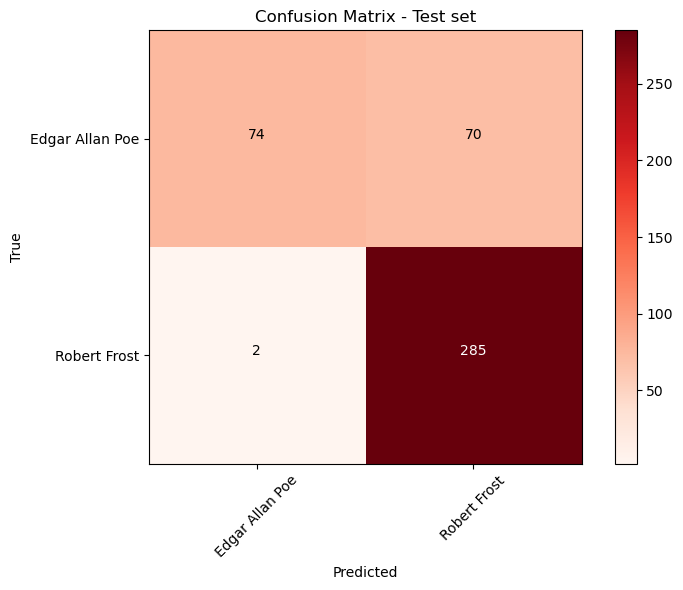

In [224]:
class_labels = ['Edgar Allan Poe', 'Robert Frost']
plot_confusion_matrix(cm_test, class_labels, "Confusion Matrix - Test set")